In [1]:
import ramanchada2 as rc2
import ramanchada2.misc.constants  as rc2const
import ramanchada2.misc.utils as rc2utils
import matplotlib.pyplot as plt
import numpy as np

In [2]:
laser_wl = 785
spe_neon = rc2.spectrum.from_test_spe(sample=['Neon'], provider=['FNMT'], OP=['03'], laser_wl=['785'])
spe_pst = rc2.spectrum.from_test_spe(sample=['PST'], provider=['FNMT'], OP=['03'], laser_wl=['785'])
spe_sil = rc2.spectrum.from_test_spe(sample=['S0B'], provider=['FNMT'], OP=['03'], laser_wl=['785'])
spe_nCal = rc2.spectrum.from_test_spe(sample=['nCAL'], provider=['FNMT'], OP=['03'], laser_wl=['785'])

In [3]:
def iter_calib(in_spe, ref, prominence, wlen, n_iters, poly_order=3):
    tmp = in_spe
    for iter in range(n_iters):
        tmp = tmp.xcal_fine(ref=ref,
                            poly_order=poly_order,
                            should_fit=False,
                            find_peaks_kw=dict(prominence=tmp.y_noise*prominence,
                                               wlen=wlen,
                                               width=1,
                                              )
                           )
    return tmp

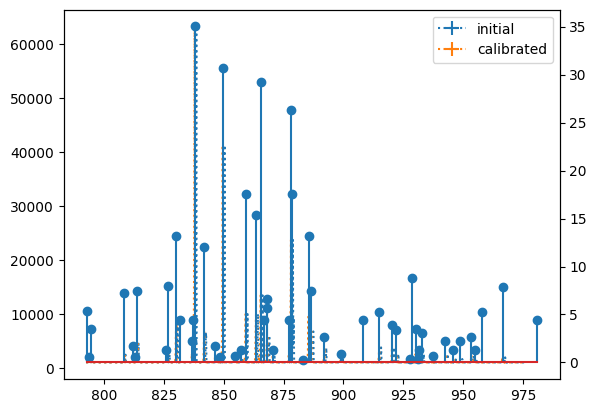

In [4]:
spe_neon_wl = spe_neon.shift_cm_1_to_abs_nm_filter(laser_wave_length_nm=laser_wl)

spe_neon_wl_calib = iter_calib(spe_neon_wl, ref=rc2const.neon_wl_785_nist_dict, wlen=100, prominence=.5, n_iters=20)
fig, ax = plt.subplots()
spe_neon_wl.plot(ax=ax, fmt=':', label='initial')
spe_neon_wl_calib.plot(ax=ax, fmt=':', label='calibrated')
ax.twinx().stem(rc2const.neon_wl_785_nist_dict.keys(), rc2const.neon_wl_785_nist_dict.values(), label='reference')

spe_neon_calib = spe_neon_wl_calib.abs_nm_to_shift_cm_1_filter(laser_wave_length_nm=laser_wl)

<Axes: >

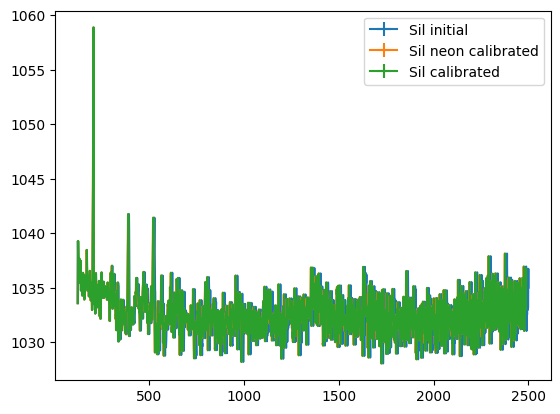

In [5]:
spe_sil_necal = spe_sil.__copy__()
spe_sil_necal.x = spe_neon_calib.x
spe_sil_calib = iter_calib(spe_sil_necal, ref=[520.45], wlen=100, prominence=10, n_iters=1, poly_order=0)
fig, ax = plt.subplots()
spe_sil.plot(ax=ax, label='Sil initial')
spe_sil_necal.plot(ax=ax, label='Sil neon calibrated')
spe_sil_calib.plot(ax=ax, label='Sil calibrated')

<Axes: >

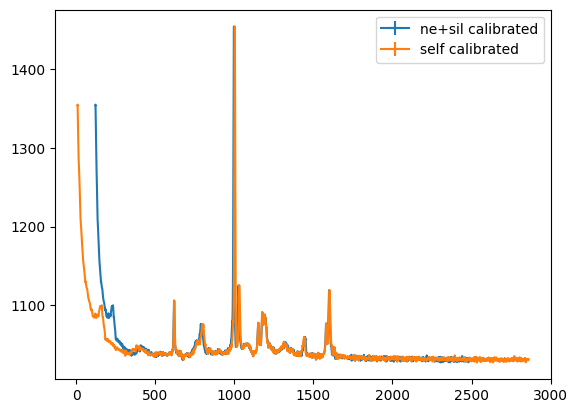

In [6]:
spe_pst_silcal = spe_pst.__copy__()
spe_pst_silcal.x = spe_sil_calib.x

spe_pst_calib = iter_calib(spe_pst_silcal, ref=rc2const.PST_RS_dict, prominence=1, wlen=100, n_iters=20)
fig, ax = plt.subplots()
spe_pst_silcal.plot(ax=ax, label='ne+sil calibrated')
spe_pst_calib.plot(ax=ax, label='self calibrated')

In [7]:
spe_nCal_movmin = spe_nCal - spe_nCal.moving_minimum(120)
spe_nCal_calib = spe_nCal_movmin.__copy__()
spe_nCal_calib.x = spe_pst_calib.x

(300.0, 1000.0)

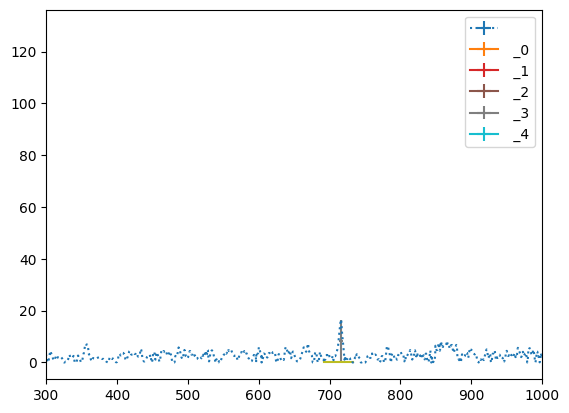

In [8]:
cand = spe_nCal_calib.find_peak_multipeak(prominence=spe_pst_calib.y_noise*10, wlen=300, width=1)

fig, ax = plt.subplots()
spe_nCal_calib.plot(ax=ax, fmt=':')
cand.plot(ax=ax)
ax.set_xlim(300, 1000)

(300.0, 1000.0)

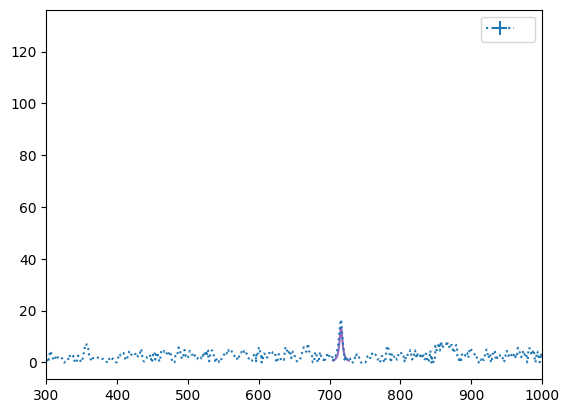

In [9]:
init_guess = spe_nCal_calib.fit_peak_multimodel(profile='Moffat', candidates=cand, no_fit=True)
fig, ax = plt.subplots()
spe_nCal_calib.plot(ax=ax, fmt=':')
init_guess.plot(ax=ax)
ax.set_xlim(300, 1000)

(300.0, 1000.0)

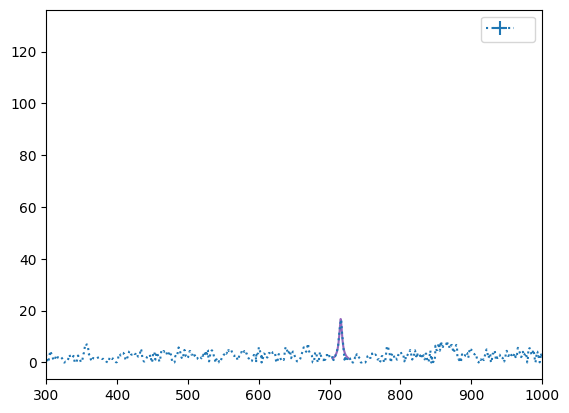

In [10]:
fit_res = spe_nCal_calib.fit_peak_multimodel(profile='Moffat', candidates=cand)
fig, ax = plt.subplots()
spe_nCal_calib.plot(ax=ax, fmt=':')
fit_res.plot(ax=ax)
ax.set_xlim(300, 1000)